# Mode-Turbulence Coupling: Numerical Analysis
# Test to eleminiate the over-and underflows
## define and employ new constants C0'[i] = exp(-aT[i]/2)*C0[i] and C1'[i] = exp(-aT[i]/2)*C1[i], with T(=Tturb) = T[i] + \deltaT.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from scipy import integrate
import random
from scipy.integrate import quad
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import math
import scipy.interpolate as interpolate

## Parameters

In [19]:
n_bins=40
#n_samples is the number of eddy turnovers
n_samples=80

Tr =2*np.pi

#variables for generating F1
meanF1 = 0
stdF1 =.3

#variables for generating F2

stdF2 =.09
meanF2=0

#initial conditions A(0)=0, dA/dT(0)=0

dAdT=0
AT=0


## Functions

In [34]:
def rayleighdistribution():

    rayleigh = np.random.rayleigh(2*np.pi, 1000)
    count, bins, ignored = plt.hist(rayleigh, 80, density=True)
    plt.title("Rayleigh Distribution")
    plt.xlabel("Delta T")
    plt.show()
    
# Source: https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.rayleigh.html

def fundeltaT(n_bins, n_samples):
    rayleigh = np.random.rayleigh(2*np.pi, 1000)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    deltaT=inv_cdf(r)
    return deltaT

# Source: https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/

# Tturb adds up the delta T's

def funTturb():
    Tturb=[0]
    for i in range(len(deltaT)-1):
        Tturb.append(deltaT[i]+Tturb[i])
    return Tturb

# t is the sum of half way points of consecutive delta T's

def funt():
    t=[]
    for i in range(len(deltaT)-1):
        t.append((deltaT[i])/2+(deltaT[i+1])/2)
    return t

def funF1(meanF1, stdF1, Tr):

    y1=.1
    F1=[]
    prob=[]

    for i in range(len(t)):
        arr=[]
        a=t[i]
        stdevt=((1-math.exp(-2*a/Tr))*stdF1**2)**(1/2)
        meant=math.exp(-a/Tr)*y1
        R=random.uniform(0,1)
        F1.append(meant-stdevt+2*stdevt*R)
    return F1

def funF2(meanF2, stdF2, Tr):

    y1=.01
    F2=[]

    for i in range(len(t)):
        arr=[]
        a=t[i]
        stdevt=((1-math.exp(-2*a/Tr))*stdF2**2)**(1/2)
        meant=math.exp(-a/Tr)*y1
        R=random.uniform(0,1)
        F2.append(meant-stdevt+2*stdevt*R)
    return F2

#To Generate G1, I take the derivative of F1 by taking the difference of F1 values at times halfway between consecutive delta T's and divide that by the difference in those times

def funG1():

    G1=[0]
    for i in range(len(F1)-1):
        G1.append((F1[i+1]-F1[i])/(deltaT[i]+deltaT[i+1]))
    return G1


def funAmp(dAdT, AT):

    #A is the amplitude
    A=[]
    #t is time
    t=[]
    #derivA is the derivative of A with respect to time
    derivA=[]
    
    #F2=constant=c
    #1+G1=constant=b
    #F1=constant=a
    ## a**2<4*b is always the case
    for i in range(len(Tturb)-1):
        a=F1[i]
        b=G1[i]+1
        c=F2[i]
        q=1/2*(4*b-a**2)**(1/2)
        #Ttemp is the time between each eddy turnover (which starts at Tturb[i] and ends at Tturb[i+1])
        Ttemp=np.linspace(Tturb[i], Tturb[i+1])
        #deltaT is the length of each eddy
        deltaT=Tturb[i+1]-Tturb[i]
        
        C0=(math.exp(a*Tturb[i]/2)*dAdT+(a/2+q*math.tan(q*Tturb[i]))*(AT-c/b)*(math.exp(a*Tturb[i]/2)))*(math.cos(q*Tturb[i])/q)
        C0prime=math.exp(-a*(Tturb[i]-deltaT)/2)*C0
        C1=(AT-c/b)*math.exp(a*Tturb[i]/2)/math.cos(q*Tturb[i])-C0*math.tan(q*Tturb[i])
        C1prime=math.exp(-a*(Tturb[i]-deltaT)/2)*C1
        
        #this for loop below loops through each eddy turnover:
        for j in Ttemp:
            if j==Tturb[i]:
                pass
            else:
                t.append(j)
                A.append(math.exp(-a*j/2)*(C0prime*math.sin(q*j)+C1prime*math.cos(q*j))+c/b)
                derivA.append(math.exp(-a*j/2)*(-a/2*(C0prime*math.sin(q*j)+C1prime*math.cos(q*j))+q*C0prime*math.cos(q*j)-q*C1prime*math.sin(q*j)))
        #resets the initial conditions for the next eddy turnovers to match the conditions at the end of the previous eddy turnover
        dAdT=derivA[-1]
        AT=A[-1]
    
    return A, t

In [35]:
def FunavgA(A):
    Asqr=[]
    for i in A:
        Asqr.append(i**2)
    avg=sum(Asqr)/len(Asqr)
    return avg

def FunLog(A):
    logA=[]
    for i in A:
        logA.append(math.log10(abs(i)))
    return logA

### Keep T and F2 constant and change F1 and G1

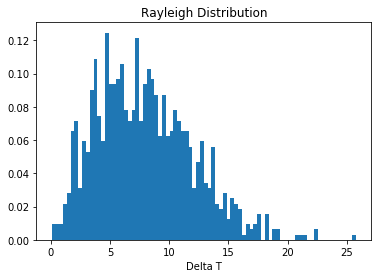

In [36]:
rayleighdistribution()

deltaT=fundeltaT(n_bins, n_samples)


Tturb=funTturb()

t=funt()

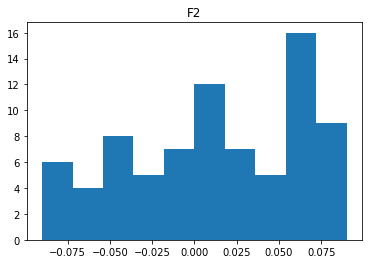

In [38]:
F2=funF2(meanF2, stdF2, Tr)
plt.hist(F2, 10, range=(-stdF2, stdF2))
plt.title("F2")
plt.show()

## Outputs

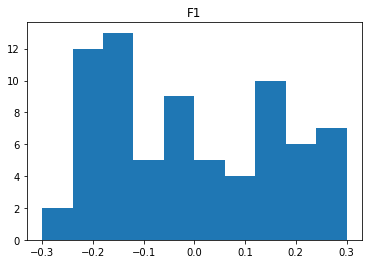

<F1^2>^(1/2) =  0.18390158286862765


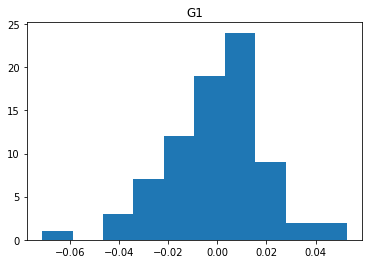

In [39]:
F1=funF1(meanF1, stdF1, Tr)
plt.hist(F1, 10, range=(-stdF1, stdF1))
plt.title("F1")
plt.show()

F1sqr=[]
for i in range(len(F1)):
    F1sqr.append(F1[i]**2)
rms=(sum(F1sqr) / len(F1sqr) )**(1/2)
print("<F1^2>^(1/2) = ", rms)
    

G1=funG1()
plt.hist(G1, 10)
plt.title("G1")
plt.show()

### Amplitude of mode

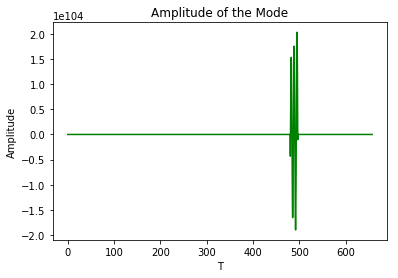

Amplitude of mode for 80 eddy turnovers

 Average value of the amplitude squared = 1.9564685701845983e+206


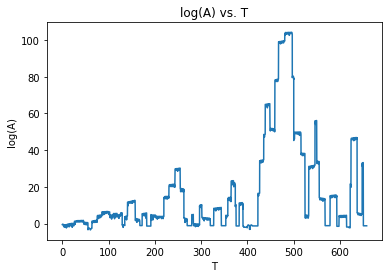

In [40]:
A, t =funAmp(dAdT, AT)
plt.plot(t, A, 'g')
plt.xlabel('T')
plt.ylabel('Amplitude')
plt.title('Amplitude of the Mode')
plt.show()

avg= FunavgA(A)

print("Amplitude of mode for" , n_samples, "eddy turnovers")
print("\n Average value of the amplitude squared =", avg)

logA=FunLog(A)

plt.plot(t,logA)
plt.xlabel('T')
plt.ylabel('log(A)')
plt.title('log(A) vs. T')
plt.show()

## Check that derivative is correct for the first three eddies

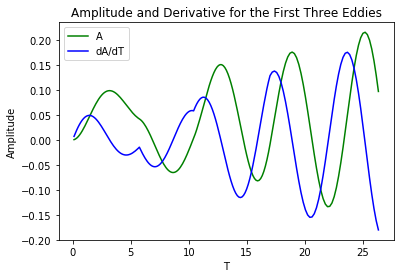

In [41]:
#FIRST EDDY TURNOVER
#check that derivative is correct

A=[]
t=[]
derivA=[]

dAdT=0
AT=0
## a**2<4*b is always the case
for i in range(4):
    a=F1[i]
    b=G1[i]+1
    c=F2[i]
    Ttemp=np.linspace(Tturb[i], Tturb[i+1])
    q=1/2*(4*b-a**2)**(1/2)
    C0=(math.exp(a*Tturb[i]/2)*dAdT+(a/2+q*math.tan(q*Tturb[i]))*(AT-c/b)*(math.exp(a*Tturb[i]/2)))*(math.cos(q*Tturb[i])/q)
    C1=(AT-c/b)*math.exp(a*Tturb[i]/2)/math.cos(q*Tturb[i])-C0*math.tan(q*Tturb[i])
    for j in Ttemp:
        if j==Tturb[i]:
            pass
        else:
            t.append(j)
            A.append(math.exp(-a*j/2)*(C0*math.sin(q*j)+C1*math.cos(q*j))+c/b)
            derivA.append(math.exp(-a*j/2)*(-a/2*(C0*math.sin(q*j)+C1*math.cos(q*j))+q*C0*math.cos(q*j)-q*C1*math.sin(q*j)))
    dAdT=derivA[-1]
    AT=A[-1]
    tend=t[-1]
    
plt.plot(t, A, 'g', label="A")
plt.plot(t, derivA, 'b', label="dA/dT")
plt.xlabel('T')
plt.ylabel('Amplitude')
plt.title('Amplitude and Derivative for the First Three Eddies')
plt.legend()